## Loading libraries and saved data

In [1]:
from pathlib import Path
import os, sys
ROOT_DIR_INSIDE = Path(os.getcwd()).parent # Path('/home/anant/PD_Subtypes_Progression') 
sys.path.append(str(Path(os.getcwd()).parent))
dataset_name = 'jul1022'

PDBP_CLINICAL_RAW_DATA_DIR_INSIDE = ROOT_DIR_INSIDE / 'raw_data/clinical/pdbp'
PDBP_CLINICAL_GEN_DATA_DIR_INSIDE = ROOT_DIR_INSIDE / 'generated_data/clinical/pdbp'
PPMI_CLINICAL_GEN_DATA_DIR_INSIDE = ROOT_DIR_INSIDE / 'generated_data/clinical/ppmi'

In [2]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from datetime import datetime
import pickle
import copy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib as mpl
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

with open(PPMI_CLINICAL_GEN_DATA_DIR_INSIDE / 'preprocessed/{}.pkl'.format(dataset_name), 'rb') as f:
    ppmi_preprocessed_data = pickle.load(f)

with open(PPMI_CLINICAL_GEN_DATA_DIR_INSIDE / 'representation_learning/{}.pkl'.format(dataset_name), 'rb') as f:
    ppmi_representation_learning_data = pickle.load(f)
    
with open(PPMI_CLINICAL_GEN_DATA_DIR_INSIDE / 'clustering/{}.pkl'.format(dataset_name), 'rb') as f:
    ppmi_clustering_data = pickle.load(f)
    
with open(PDBP_CLINICAL_GEN_DATA_DIR_INSIDE / 'preprocessed/{}.pkl'.format(dataset_name), 'rb') as f:
    preprocessed_data = pickle.load(f)
    
with open(PDBP_CLINICAL_GEN_DATA_DIR_INSIDE / 'representation_learning/{}.pkl'.format(dataset_name), 'rb') as f:
    representation_learning_data = pickle.load(f)
    
with open(PDBP_CLINICAL_GEN_DATA_DIR_INSIDE / 'clustering/{}.pkl'.format(dataset_name), 'rb') as f:
    clustering_data = pickle.load(f)

input_data = {}
input_data.update(preprocessed_data)
input_data.update(representation_learning_data)
input_data.update(clustering_data)

ppmi_input_data = {}
ppmi_input_data.update(ppmi_preprocessed_data)
ppmi_input_data.update(ppmi_representation_learning_data)
ppmi_input_data.update(ppmi_clustering_data)
datasets = input_data['data_names']
plt.rcParams.update({"savefig.format": 'png'})


In [3]:
sns.set(context='notebook', style='ticks', font_scale=1.6, font='sans-serif', rc={"lines.linewidth": 1.2})
sns.set_style("white")
# plt.style.use('default')
# plt.rcParams.update({'font.size':20})

dset = datasets[0]
Labels_ppmi = ppmi_clustering_data['d_M_PD_HC_gmm_chosen']['paper_experiment_replication'] # [dset]
Labels_ppmi['GMM'] = Labels_ppmi['GMM_2d_adj']
Labels = input_data['d_M_PD_HC_gmm_chosen']['paper_experiment_replication'] # [dset]
Labels['GMM'] = Labels['GMM_2d_adj']
ecat_ppmi = Labels_ppmi.copy()
ecat_pdbp = Labels.copy()
ecat_ppmi['GMM'] = Labels_ppmi['GMM'].map(lambda x: 'Control' if x=='HC' else 'PD')
ecat_pdbp['GMM'] = Labels['GMM'].map(lambda x: 'Control' if x=='Control' else 'PD')

palette_progression = {'PDvec3':'orange', 'PDvec2': 'blue', 'PDvec1':'green', 'Non-PD':'red'}
subtype_order = ['PDvec3', 'PDvec2', 'PDvec1', 'Non-PD']
subtype_replace = {'PD_h':'PDvec3', 'PD_m': 'PDvec2', 'PD_l':'PDvec1', 'HC':'Non-PD', 'Control': 'Non-PD'}
subtype_column = {'GMM': 'Subtypes'}
color_patch = []
for lab, color in palette_progression.items():
    color_patch.append(mpatches.Patch(color=color, label=lab))

## Cohort Validation Test

### Age at screening
#### Q: How do you calculate the age at screening in ppmi and pdbp?

In [4]:
age_ppmi = ppmi_preprocessed_data['data']['paper_experiment_replication']['screening'].copy()
status = ppmi_preprocessed_data['data']['paper_experiment_replication']['status'].copy()
age_ppmi = pd.merge(age_ppmi, status, left_index=True, right_index=True)
age_ppmi['Age'] = (pd.to_datetime(age_ppmi['ENROLL_DATE']) - pd.to_datetime(age_ppmi['BIRTHDT'])).astype('timedelta64[Y]')
age_ppmi['Age_2019'] = (pd.to_datetime('2019-01-01') - pd.to_datetime(age_ppmi['BIRTHDT'])).astype('timedelta64[Y]')
age_ppmi['Age'] = (pd.to_datetime(age_ppmi['ENROLL_DATE']) - pd.to_datetime(age_ppmi['BIRTHDT'])).astype('timedelta64[Y]')
# age_ppmi['Age_2019'] = (2019 - pd.to_datetime(age_ppmi['BIRTHDT']).map(lambda x: x.year))
age_ppmi = pd.merge(age_ppmi, ecat_ppmi, left_index=True, right_index=True)

age_pdbp = input_data['data']['paper_experiment_replication']['pdbp_info'].copy()
age_pdbp['date_offset'] = age_pdbp['Age'].map(lambda x: pd.DateOffset(years=int(x)))
age_pdbp['BIRTHDT'] = (pd.to_datetime(age_pdbp['VisitDate']) - age_pdbp['date_offset']).dt.tz_localize(None)
age_pdbp = pd.merge(age_pdbp, ecat_pdbp, left_index=True, right_index=True, how='outer')
age_pdbp['Age_2019'] = (pd.to_datetime('2019-01-01') - pd.to_datetime(age_pdbp['BIRTHDT'])).astype('timedelta64[Y]')
# age_pdbp['Age_2019'] = (2019 - pd.to_datetime(age_pdbp['BIRTHDT']).map(lambda x: x.year))

# age_ppmi['Age_other'] = age_ppmi.index.map(lambda x: mapping_age.get('PP-'+str(x), np.nan))
# age_pdbp['Age_other'] = age_pdbp.index.map(lambda x: mapping_age.get('PD-'+str(x), np.nan))

In [5]:
# sns.kdeplot(age_ppmi[age_ppmi['GMM']=='PD']['BIRTHDT'].map(lambda x: x.year), label='ppmi birth')
# sns.kdeplot(age_pdbp[age_pdbp['GMM']=='PD']['BIRTHDT'].map(lambda x: x.year), label='pdbp birth')
# plt.xlabel('Birth Year')
# rvs1 = age_ppmi[age_ppmi['GMM']=='PD']['BIRTHDT'].map(lambda x: x.year).dropna()
# rvs2 = age_pdbp[age_pdbp['GMM']=='PD']['BIRTHDT'].map(lambda x: x.year).dropna()
# from scipy import stats
# print ('Age: PPMI-PD', np.mean(rvs1).round(2),
#       'PDBP-PD', np.mean(rvs2).round(20))
# stats.ttest_ind(rvs1,rvs2)

### UPDRS3 score

In [6]:
P = ppmi_preprocessed_data['P_d'][dset]
P_temp = P[['attribute', 'feature']].groupby('feature').agg(lambda x: list(x))# .reset_index()
feature_attribute_mapping = dict(zip(list(P_temp.index), list(P_temp['attribute'])))
ppmi_updrs_cols = feature_attribute_mapping['updrs3']

ppmi_M_chosen = ppmi_preprocessed_data['M_orig'][dset]
ppmi_M_chosen_bl = ppmi_M_chosen.loc[:, ppmi_M_chosen.columns.get_level_values(-1)=='BL']
ppmi_M_chosen_bl_updrs = ppmi_M_chosen_bl.loc[:, ppmi_M_chosen_bl.columns.get_level_values(0).isin(ppmi_updrs_cols)]
ppmi_M_chosen_updrs = ppmi_M_chosen_bl_updrs.sum(axis=1).reset_index().set_index('PATNO').rename(columns={0: 'MDS-UPDRSIII'})
ppmi_M_chosen_updrs = pd.merge(ppmi_M_chosen_updrs, ecat_ppmi, left_index=True, right_index=True)

In [7]:
pbdp_M_chosen = preprocessed_data['M_orig'][dset]
pbdp_M_chosen_bl = pbdp_M_chosen.loc[:, pbdp_M_chosen.columns.get_level_values(0)=='Baseline']
pbdp_M_chosen_bl_updrs = pbdp_M_chosen_bl.loc[:, pbdp_M_chosen_bl.columns.get_level_values(1).isin(['MDSUPDRS_PartIIIScore'])]
pbdp_M_chosen_bl_updrs.columns = ['MDS-UPDRSIII']
pbdp_M_chosen_bl_updrs = pd.merge(pbdp_M_chosen_bl_updrs, ecat_pdbp, left_index=True, right_index=True)

In [8]:
enroll_cat = preprocessed_data['data']['paper_experiment_replication']['pdbp_info']
enroll_cat = enroll_cat[enroll_cat['ENROLL_CAT']=='Case']

In [9]:
all_scores = preprocessed_data['data']['paper_experiment_replication']['updrs'].set_index('PATNO')
all_case = all_scores[all_scores['EVENT_ID']=='Baseline'].loc[list(set(enroll_cat.index).intersection(all_scores.index))]['MDSUPDRS_PartIIIScore']

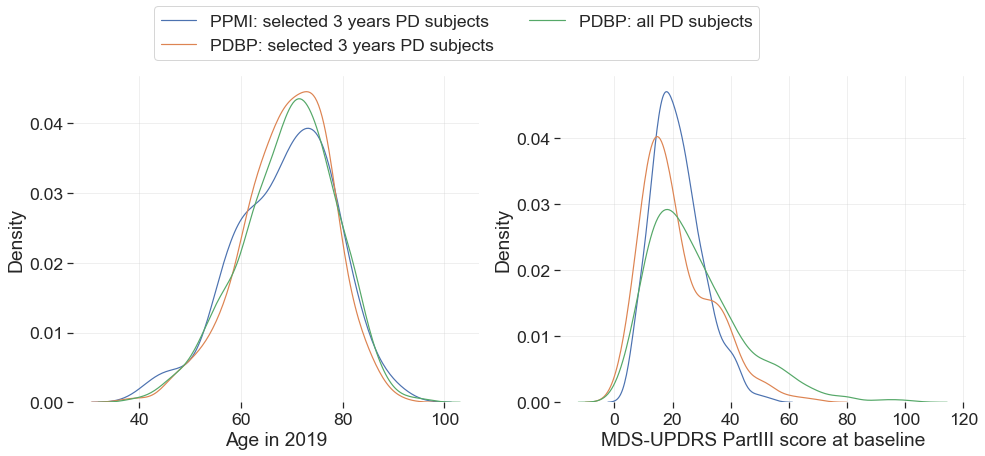

In [10]:
sns.set(context='notebook', style='ticks', font_scale=1.6, font='sans-serif', rc={"lines.linewidth": 1.2})
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
fig, axslist = plt.subplots(1, 2, figsize=(8*2, 3*2))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for e in range(len(axslist)):
    axslist[e].spines['top'].set_visible(False)
    axslist[e].spines['right'].set_visible(False)
    axslist[e].spines['left'].set_visible(False)
    axslist[e].spines['bottom'].set_visible(False)
    axslist[e].grid(True, alpha=0.3)
    axslist[e].set_ylabel('Density')
    if e==0:
        sns.kdeplot(age_ppmi[age_ppmi['GMM']=='PD']['Age_2019'], label='PPMI: selected 3 years PD subjects', ax=axslist[e])
        sns.kdeplot(age_pdbp[age_pdbp['GMM']=='PD']['Age_2019'], label='PDBP: selected 3 years PD subjects', ax=axslist[e])
        sns.kdeplot(age_pdbp[age_pdbp['ENROLL_CAT']=='Case']['Age_2019'], label='PDBP: all PD subjects', ax=axslist[e])
        axslist[e].set_xlabel('Age in 2019')
    else:
        sns.kdeplot(ppmi_M_chosen_updrs[ppmi_M_chosen_updrs['GMM']=='PD']['MDS-UPDRSIII'], ax=axslist[e], label='PPMI: selected 3 years PD subjects')
        sns.kdeplot(pbdp_M_chosen_bl_updrs[pbdp_M_chosen_bl_updrs['GMM']=='PD']['MDS-UPDRSIII'], ax=axslist[e], label='PDBP: selected 3 years PD subjects')
        sns.kdeplot(list(all_case), ax=axslist[e], label='PDBP: all PD subjects')
        axslist[e].set_xlabel('MDS-UPDRS PartIII score at baseline')
    if e==0:
        axslist[e].legend(bbox_to_anchor=(0.2, 1.05), loc='lower left', borderaxespad=0., ncol=2)
    else:
        pass
        # axslist[e].legend_.remove()
    # fig.savefig('images/Fig8_validation_test', dpi=200, bbox_inches = "tight")

In [11]:
rvs1 = age_ppmi[age_ppmi['GMM']=='PD']['Age_2019'].dropna().values
rvs2 = age_pdbp[age_pdbp['GMM']=='PD']['Age_2019'].dropna().values
from scipy import stats
print ('Age: PPMI-PD', np.mean(rvs1).round(2),
      'PDBP-PD', np.mean(rvs2).round(20))
print ('Age', stats.ttest_ind(rvs1,rvs2))

from scipy import stats
rvs1 = ppmi_M_chosen_updrs[ppmi_M_chosen_updrs['GMM']=='PD']['MDS-UPDRSIII']
rvs2 = pbdp_M_chosen_bl_updrs[pbdp_M_chosen_bl_updrs['GMM']=='PD']['MDS-UPDRSIII']
print ('UPDRS', stats.ttest_ind(rvs1,rvs2))

Age: PPMI-PD 68.68 PDBP-PD 68.99619771863118
Age Ttest_indResult(statistic=-0.41274880352554544, pvalue=0.6799426708731484)
UPDRS Ttest_indResult(statistic=0.29090762868641373, pvalue=0.7712256040563387)


## 3D progression space plots

In [12]:
visits_list = ['Baseline', '12 months', '24 months', '36 months']

dims = 3
model = input_data['nmf3_model'][datasets[0]]
df = pd.DataFrame(model.components_)
cols = input_data['M_chosen'][datasets[0]].columns
df.columns = cols
LW = []
for i in visits_list:
    temp = df.loc[:, df.columns.get_level_values(-1)==i]
    temp.columns = temp.columns.get_level_values(0)
    LW.append(temp)

P_3d = pd.concat([i.round(2) for i in LW], axis=0)
K = []
for i in visits_list:
    K.extend(['C{}-'.format(j)+i for  j in range(int(dims))])
P_3d.index = K
P_3d = P_3d.sort_index()
A = (P_3d.loc[P_3d.index.str.contains('36 months')].T.sum(axis=1)<=0.05)
sel_3d = A[~A].index
# gdash = sns.clustermap(P_3d.loc[P_3d.index.str.contains('36 months')].T.loc[sel_3d]+0.001, cmap=plt.cm.Blues, vmin=0, vmax=0.7, dendrogram_ratio=0.001, col_cluster=True,
#               cbar_pos=None, figsize=(30, 40), standard_scale=None, annot=True, yticklabels=True, z_score=None)
# plt.savefig('images_discuss_rough/projection_matrix.pdf')

In [13]:
# at baseline it shows the best clusters with respect to sleep, so we took those features
visits_list = ['Baseline', '12 months', '24 months', '36 months']
last_visit = visits_list[-1]
progression_space_3d_adj_list = []
adjust_matrix_weights = {}
for visit in visits_list:
    if visit== last_visit:
        visit = ''
    else:
        visit = '_' + visit
    temp = input_data['nmf3_projection_cluster']['{}{}'.format(dset, visit)][1]
    temp['Subtypes'] = Labels.loc[list(set(temp.index).intersection(Labels.index)), 'GMM']
    progression_space_3d_adj_list.append(temp.dropna().replace(subtype_replace))


In [14]:
temp['Subtypes'].value_counts()

PD_l       121
Control    115
PD_h        82
PD_m        60
Name: Subtypes, dtype: int64

#### Get PPMI Progression Space

In [15]:
# at baseline it shows the best clusters with respect to sleep, so we took those features
visits_list = ['BL', 'V04', 'V06', 'V08']
ppmi_progression_space_3d_adj_list = []
adjust_matrix_weights = {}
for visit in visits_list:
    if visit == visits_list[-1]:
        visit = ''
    else:
        visit = '_' + visit
    temp = ppmi_input_data['nmf3_projection_cluster']['{}{}'.format(dset, visit)][1]
    temp['Subtypes'] = Labels_ppmi.loc[list(set(temp.index).intersection(Labels_ppmi.index)), 'GMM']
    ppmi_progression_space_3d_adj_list.append(temp.dropna().replace(subtype_replace))

In [16]:
ppmi_progression_space_3d = ppmi_progression_space_3d_adj_list[-1].copy()
pdbp_progression_space_3d = progression_space_3d_adj_list[-1].copy()
# ppmi_progression_space_3d = pd.read_csv('data/ppmi_progression_space_3d.csv').set_index('PATNO')
ppmi_progression_space_3d['dataset'] = 'ppmi'
# pdbp_progression_space_3d = progression_space_3d_list[-1]
pdbp_progression_space_3d['dataset'] = 'pdbp'
progression_space_3d_Y3_visit = pd.concat([ppmi_progression_space_3d, pdbp_progression_space_3d], axis=0)

### Projection Matrix

In [17]:
# sns.clustermap(P_3d.T, cmap=plt.cm.Blues, vmin=0, vmax=1, dendrogram_ratio=0.001, col_cluster=False,
#              cbar_pos=None, figsize=(60, 40), standard_scale=0, annot=True, yticklabels=True)
# plt.savefig('images_check/up_{}d_dimension_plot.pdf'.format(dims), dpi=80)

In [18]:
pdbp_progression_space_3d['Sleep dimension'].var(), pdbp_progression_space_3d['Motor dimension'].var(), pdbp_progression_space_3d['Cognitive dimension'].var()

(0.041816563044262456, 0.04443997954273414, 0.009770441042056852)

### Final Visit-3D scatter plot

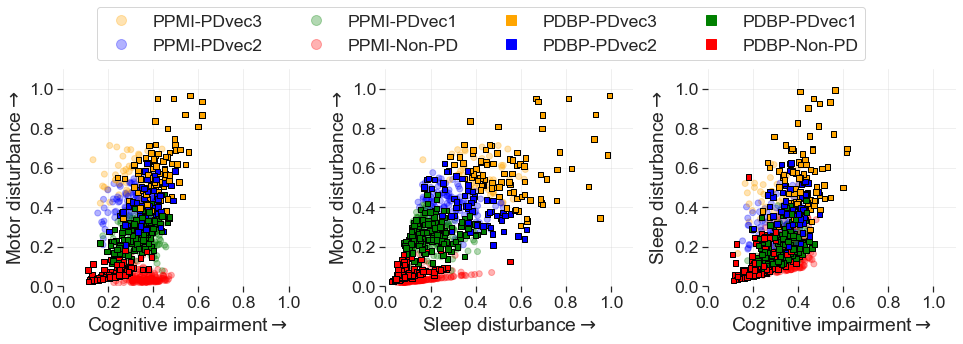

In [19]:
fig, axislist = plt.subplots(1, 3, figsize=(16, 4))
plt.subplots_adjust(hspace=0.2, wspace=0.3)
axs = axislist.reshape(-1)
for enm, progression_space_3d in enumerate([(ppmi_progression_space_3d, pdbp_progression_space_3d), ]):
    ppmi, pdbp = progression_space_3d
    # progression_space_3d['marker'] = progression_space_3d['dataset'].map(lambda x: 's' if x=='ppmi' else 'o')
    columns = [('Motor dimension', 'Cognitive dimension'), ('Motor dimension', 'Sleep dimension'), ('Sleep dimension', 'Cognitive dimension')]
    color_patch = []
    for lab, color in palette_progression.items():
        color_patch.append(mpatches.Patch(color=color, label=lab))
        
    for i in range(3):
        ax = axs[enm*3 + i]
        # sns.scatterplot(y=columns[i][0], hue='Subtypes', x=columns[i][1], ax=ax, data=progression_space_3d, palette=palette_progression, alpha=0.9, markers='s')
        min_y = min(ppmi[columns[i][0]].min(), pdbp[columns[i][0]].min()) + 0.05
        min_x = min(ppmi[columns[i][1]].min(), pdbp[columns[i][1]].min()) + 0.05
        max_y = max(ppmi[columns[i][0]].max(), pdbp[columns[i][0]].max()) + 0.05
        max_x = max(ppmi[columns[i][1]].max(), pdbp[columns[i][1]].max()) + 0.05
        ax.scatter(y=ppmi[columns[i][0]], x=ppmi[columns[i][1]], c=ppmi['Subtypes'].map(lambda x: palette_progression[x]), marker='o', alpha=0.3)
        ax.scatter(y=pdbp[columns[i][0]], x=pdbp[columns[i][1]], c=pdbp['Subtypes'].map(lambda x: palette_progression[x]), marker='s', edgecolors='black', s=30)
        label_name = [('Motor disturbance', 'Cognitive impairment'), ('Motor disturbance', 'Sleep disturbance'), ('Sleep disturbance', 'Cognitive impairment')]
        ax.set_xlabel(r'{}$\rightarrow$'.format(label_name[i][1]))
        ax.set_ylabel(r'{}$\rightarrow$'.format(label_name[i][0]))
        # ax.legend_.remove()
        start_y, start_x = list(pdbp[pdbp['Subtypes']=='Non-PD'].loc[:, columns[i]].mean(axis=0))
        start_y, start_x = 0, 0
        # ax.arrow(0, 0, start_x, start_y, width=0.01, color=palette_progression['Non-PD'], length_includes_head=True)
        for subtype in ['PDvec3', 'PDvec2', 'PDvec1', 'Non-PD']:
        # for subtype in ['PD', 'Non-PD']:
            end_y, end_x = list(pdbp[pdbp['Subtypes']==subtype].loc[:, columns[i]].mean(axis=0))
            # ax.arrow(start_x, start_y, end_x-start_x, end_y-start_y, width=0.007, color=palette_progression[subtype], length_includes_head=True)
            # print (subtype, end_x, end_y)
            # ax.axvline(x=end_x, ymin=start_y, ymax=1, alpha=0.5, color=palette_progression[subtype])
            # ax.axhline(y=end_y, xmin=start_x, xmax=1, alpha=0.5, color=palette_progression[subtype])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(True, alpha=0.3)
        limit_x = 1.1
        limit_y = 1.1
        ax.set_ylim(0, limit_y)
        ax.set_xlim(0, limit_x)
        ax.set_xticks(list(np.arange(0, limit_x+0.05, 0.2)), None)
        ax.set_yticks(list(np.arange(0, limit_y+0.05, 0.2)), None)
        # print (np.arange(0, 0.65, 0.05))
        empty_string_labels = [str(ep) for ep in range(len(np.arange(0, max_x+0.05, 0.05)))]#['']*len(list(np.arange(0, 0.6, 0.05)))
        empty_string_labels_y = [str(ep) for ep in range(len(np.arange(0, max_y+0.05, 0.05)))]
        if i == 0:
            square_patch = []
            circle_patch = []
            for lab, color in palette_progression.items():
                # color_patch.append(mpatches.Patch(color=color, label=lab))
                circle_patch.append(plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=color, label='PPMI-'+lab, alpha=0.3)[0])
                square_patch.append(plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=color, label='PDBP-'+lab)[0])
            ax.legend(handles=circle_patch+square_patch, bbox_to_anchor=(0.1, 1), loc='lower left', ncol=4, numpoints=1 )
        # ax.set_xticklabels(empty_string_labels)
        # ax.set_yticklabels(empty_string_labels_y)
    # ax.set_title(dset.split('_')[-1])
# fig.savefig('images/Fig10_detailed_snapshot', dpi=200, bbox_inches = "tight")

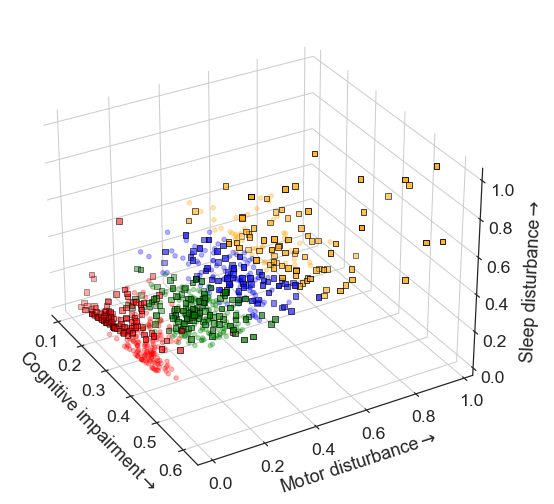

In [20]:
for enm, progression_space_3d in enumerate([(ppmi_progression_space_3d, pdbp_progression_space_3d), ]):
    ppmi, pdbp = progression_space_3d
    y_axis = 'Motor dimension'
    z_axis = 'Sleep dimension'
    x_axis = 'Cognitive dimension'
    y_axis = 'Motor dimension'
    z_axis = 'Sleep dimension'
    x_axis = 'Cognitive dimension'
    label_name = {'y_axis': 'Motor disturbance', 'x_axis': 'Cognitive impairment', 'z_axis': 'Sleep disturbance'}
    my_dpi=96

    width = 11
    size_variation = 3
    fig = plt.figure(figsize=(4*size_variation, 3*size_variation))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(ppmi[x_axis], ppmi[y_axis], ppmi[z_axis], c=ppmi['Subtypes'].map(lambda x: palette_progression[x]), marker='o', alpha=0.3)
    ax.scatter(pdbp[x_axis], pdbp[y_axis], pdbp[z_axis], c=pdbp['Subtypes'].map(lambda x: palette_progression[x]), marker='s', edgecolors='black', s=30)
    for subtype, color in palette_progression.items():
        x_meanpt = pdbp.groupby('Subtypes').agg('mean').loc[subtype][x_axis]
        y_meanpt = pdbp.groupby('Subtypes').agg('mean').loc[subtype][y_axis]
        z_meanpt = pdbp.groupby('Subtypes').agg('mean').loc[subtype][z_axis]
        mean_line = [(0, x_meanpt), (0, y_meanpt), (0, z_meanpt)]
        # ax.plot(mean_line[0], mean_line[1], mean_line[2], color=color, linewidth=4, markersize=12)
    
    # make simple, bare axis lines through space:
    # xAxisLine = ((min(result[x_axis]), max(result[x_axis])), (0, 0), (0,0))
    # ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'b')
    # yAxisLine = ((0, 0), (min(result[y_axis]), max(result[y_axis])), (0,0))
    # ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'b')
    # zAxisLine = ((0, 0), (0,0), (min(result[z_axis]), max(result[z_axis])))
    # ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'b')
 
    # label the axes
    ax.set_xlabel(r'{}$\rightarrow$'.format(label_name['x_axis']), labelpad=10, fontsize=18)
    ax.set_ylabel(r'{}$\rightarrow$'.format(label_name['y_axis']), labelpad=10, fontsize=18)
    ax.set_zlabel(r'{}$\rightarrow$'.format(label_name['z_axis']), labelpad=10, fontsize=18)
    ax.grid(True, alpha=0.3)
    # ax.set_xlabel(x_axis, labelpad=10, fontsize=18)
    # ax.set_ylabel(y_axis,labelpad=10, fontsize=18)
    # ax.set_zlabel(z_axis, labelpad=10, fontsize=18)
    # ax.set_xlim(0, 0.3)
    # ax.grid(True)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    # ax.set_zticklabels([])
    # ax.set_xticklabels([item.get_text() for item in ax.get_xticklabels()],fontsize=8)
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    
    ax.view_init(elev=30., azim=330)
    
    #  ax.can_zoom(True)
    plt.show()

# fig.savefig('images/Fig10_3d_view', dpi=200, bbox_inches = "tight")

In [21]:
progression_space_3d_Y3_visit

,Sleep dimension,Motor dimension,Cognitive dimension,Subtypes,dataset
PATNO,,,,,
3000,0.100344,0.058036,0.406133,Non-PD,ppmi
3001,0.305664,0.336232,0.412473,PDvec1,ppmi
3002,0.476600,0.473396,0.403303,PDvec3,ppmi
3003,0.236599,0.548180,0.360216,PDvec2,ppmi
3004,0.152929,0.069073,0.363079,Non-PD,ppmi
...,...,...,...,...,...
PDZX364DYQ,0.166334,0.075853,0.290087,Non-PD,pdbp
PDZX962WBC,0.187865,0.315505,0.315353,PDvec1,pdbp
PDZZ133PFJ,0.537825,0.395410,0.340236,PDvec3,pdbp


In [22]:
visits_list = ['BL', 'V04', 'V06', 'V08']
pdbp_ppmi_progression_space_3d_adj_list = []
for e, visit in enumerate(visits_list):
    ppmi_progression_space_3d = ppmi_progression_space_3d_adj_list[e].copy()
    pdbp_progression_space_3d = progression_space_3d_adj_list[e].copy()
    ppmi_progression_space_3d['dataset'] = 'ppmi'
    pdbp_progression_space_3d['dataset'] = 'pdbp'
    ppmi_progression_space_3d['visit'] = visit
    pdbp_progression_space_3d['visit'] = visit
    progression_space_3d_Y3_visit = pd.concat([ppmi_progression_space_3d, pdbp_progression_space_3d], axis=0)
    pdbp_ppmi_progression_space_3d_adj_list.append(progression_space_3d_Y3_visit)

In [23]:
replication_progression_space_3d = pd.concat(pdbp_ppmi_progression_space_3d_adj_list)

In [45]:
ppmi_3d = pd.read_csv("../output_files/PD_progression_latent_weights_3d.csv", sep=',')

In [46]:
a = ppmi_3d.set_index(['PATNO', 'Subtypes'])[["Sleep_dimension_V10", "Motor_dimension_V10", "Cognitive_dimension_V10"]]
a.columns = ["Sleep dimension", "Motor dimension", "Cognitive dimension"]
a['dataset'] = 'ppmi'
a['visit'] = 'V10'
b = ppmi_3d.set_index(['PATNO', 'Subtypes'])[["Sleep_dimension_V12", "Motor_dimension_V12", "Cognitive_dimension_V12"]]
b.columns = ["Sleep dimension", "Motor dimension", "Cognitive dimension"]
b['dataset'] = 'ppmi'
b['visit'] = 'V12'

In [47]:
ppmi_later_visits = pd.concat([a, b]).reset_index().set_index(['PATNO'])

In [49]:
pd.concat([replication_progression_space_3d, ppmi_later_visits], axis=0).reset_index().to_csv('../output_files/PDBP_PPMI_replication_progression_space_3d.csv', index=False)